# Implementation of Vanilla GANs model
Reference: https://arxiv.org/pdf/1406.2661.pdf

In [1]:
# Run the comment below only when using Google Colab
# !pip install torch torchvision

In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

In [3]:
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image

In [4]:
import numpy as np
import datetime
import os, sys

In [5]:
from matplotlib.pyplot import imshow, imsave
%matplotlib inline

In [6]:
MODEL_NAME = 'VanillaGAN'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
def get_sample_image(G, n_noise):
    """
        Save sample 100 images
    """
    z = torch.randn(100, n_noise).to(DEVICE)
    y_hat = G(z).view(100, 3, 32, 32)  # (100, 3, 32, 32) for CIFAR-10
    result = y_hat.cpu().data.numpy()

    # Rescale image from [-1, 1] to [0, 1]
    result = (result + 1) / 2  # Now in range [0, 1]

    # Create an empty grid to store the result images
    img = np.zeros([320, 320, 3])  # 320x320 grid to fit 10x10 images of size 32x32 with 3 channels

    for j in range(10):
        row_img = np.concatenate([result[j*10+i].transpose(1, 2, 0) for i in range(10)], axis=1)  # Concatenate horizontally
        img[j*32:(j+1)*32] = row_img  # Place in the grid vertically

    return img

In [8]:

# Example of Discriminator for CIFAR-10
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(32 * 32 * 3, 512),  # Change 784 to 32*32*3
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the image
        return self.model(x)

In [9]:
class Generator(nn.Module):
    def __init__(self, n_noise):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(n_noise, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 32 * 32 * 3),  # Output size for CIFAR-10
            nn.Tanh()  # Output in the range [-1, 1]
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), 3, 32, 32)  # Reshape into (batch_size, channels, height, width)
        return img

In [10]:
n_noise = 100

In [11]:
D = Discriminator().to(DEVICE)
G = Generator(n_noise).to(DEVICE)

In [12]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])  # for FashionMnist transforms.Normalize(mean=[0.5], std=[0.5]
])

In [13]:
cifar10 = datasets.CIFAR10(root='../data/', train=True, transform=transform, download=True)
# FashionMnist = datasets.FashionMNIST(root='../data/', train=True, transform=transform, download=True)


100%|██████████| 170M/170M [00:04<00:00, 34.5MB/s]


Extracting ../data/cifar-10-python.tar.gz to ../data/


In [14]:
batch_size = 64

In [16]:
data_loader = DataLoader(dataset=cifar10, batch_size=batch_size, shuffle=True, drop_last=True)

# data_loader = DataLoader(dataset=FashionMNIST, batch_size=batch_size, shuffle=True, drop_last=True)

In [17]:
criterion = nn.BCELoss()
D_opt = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
G_opt = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [18]:
max_epoch = 10 # need more than 10 epochs for training generator
step = 0
n_critic = 1 # for training more k steps about Discriminator

In [19]:
D_labels = torch.ones(batch_size, 1).to(DEVICE) # Discriminator Label to real
D_fakes = torch.zeros(batch_size, 1).to(DEVICE) # Discriminator Label to fake

In [20]:
if not os.path.exists('samples'):
    os.makedirs('samples')

In [21]:
import matplotlib.pyplot as plt

for epoch in range(max_epoch):
    for idx, (images, _) in enumerate(data_loader):
        # Training Discriminator
        x = images.to(DEVICE)
        x_outputs = D(x)
        D_x_loss = criterion(x_outputs, D_labels)

        z = torch.randn(batch_size, n_noise).to(DEVICE)
        z_outputs = D(G(z))
        D_z_loss = criterion(z_outputs, D_fakes)
        D_loss = D_x_loss + D_z_loss

        D.zero_grad()
        D_loss.backward()
        D_opt.step()

        if step % n_critic == 0:
            # Training Generator
            z = torch.randn(batch_size, n_noise).to(DEVICE)
            z_outputs = D(G(z))
            G_loss = criterion(z_outputs, D_labels)

            G.zero_grad()
            G_loss.backward()
            G_opt.step()

        if step % 500 == 0:
            print('Epoch: {}/{}, Step: {}, D Loss: {}, G Loss: {}'.format(epoch, max_epoch, step, D_loss.item(), G_loss.item()))

        if step % 1000 == 0:
            G.eval()
            img = get_sample_image(G, n_noise)
            plt.imsave('samples/{}_step{}.jpg'.format(MODEL_NAME, str(step).zfill(3)), img)
            G.train()
        step += 1

Epoch: 0/10, Step: 0, D Loss: 1.4099829196929932, G Loss: 0.7246899604797363
Epoch: 0/10, Step: 500, D Loss: 0.4872889518737793, G Loss: 3.6707451343536377
Epoch: 1/10, Step: 1000, D Loss: 0.1463598906993866, G Loss: 2.991860866546631
Epoch: 1/10, Step: 1500, D Loss: 0.23626671731472015, G Loss: 6.730945587158203
Epoch: 2/10, Step: 2000, D Loss: 0.29172345995903015, G Loss: 4.474058151245117
Epoch: 3/10, Step: 2500, D Loss: 0.2588071823120117, G Loss: 2.8709418773651123
Epoch: 3/10, Step: 3000, D Loss: 0.5872271656990051, G Loss: 3.58457612991333
Epoch: 4/10, Step: 3500, D Loss: 0.39797332882881165, G Loss: 2.81636381149292
Epoch: 5/10, Step: 4000, D Loss: 1.4656727313995361, G Loss: 3.653045892715454
Epoch: 5/10, Step: 4500, D Loss: 0.24047979712486267, G Loss: 1.8763272762298584


KeyboardInterrupt: 

## Visualize Sample

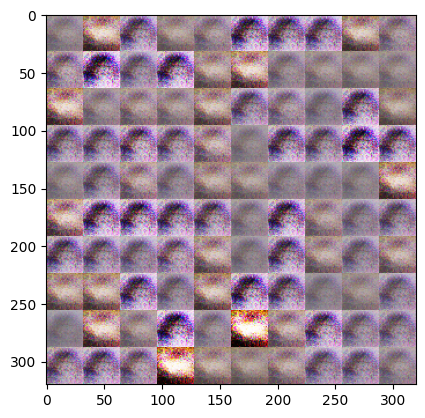

In [22]:
# generation to image
G.eval()
imshow(get_sample_image(G, n_noise))

In [23]:
# Saving params.
torch.save(D.state_dict(), 'D.pkl')
torch.save(G.state_dict(), 'G.pkl')